C:\Users\DELL\AppData\Local\Temp\ipykernel_19360\2435371319.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=connection)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19360\2435371319.py:37: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Created'] = df['Created'].fillna(method='ffill')
C:\Users\DELL\AppData\Local\Temp\ipykernel_19360\2435371319.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

Accuracy: 0.701010101010101

Confusion Matrix:
 [[321 274]
 [170 720]]

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.54      0.59       595
           1       0.72      0.81      0.76       890

    accuracy                           0.70      1485
   macro avg       0.69      0.67      0.68      1485
weighted avg       0.70      0.70      0.69      1485



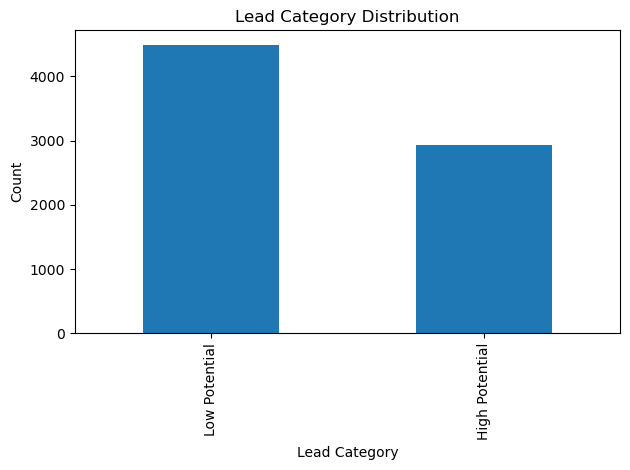

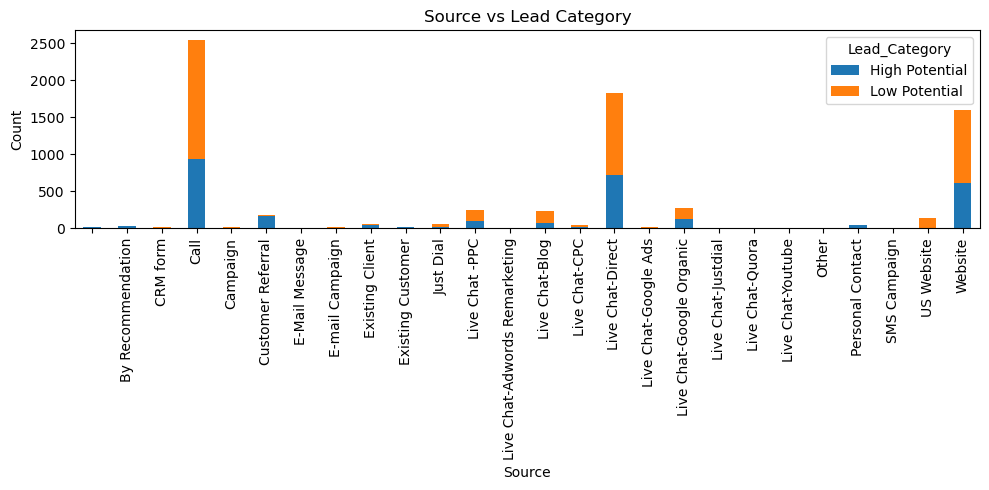

In [1]:
import mysql.connector
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import matplotlib.pyplot as plt

# Database credentials
host = '18.136.157.135'
port = 3306
database = 'project_sales'
username = 'dm_team2'
password = 'DM!$Team&27@9!20!'

# Connect to the database
connection = mysql.connector.connect(
    host=host,
    port=port,
    user=username,
    password=password,
    database=database
)

# Query to select data
query = "SELECT * FROM data"
df = pd.read_sql(query, con=connection)
connection.close()

# ---------------------------------------
# Data Cleaning and Feature Engineering
# ---------------------------------------

df['Created'] = df['Created'].replace('', pd.NaT)
df['Created'] = pd.to_datetime(df['Created'], format='%d-%m-%Y %H:%M', errors='coerce')
df['Created'] = df['Created'].fillna(method='ffill')

df['Created_Year'] = df['Created'].dt.year
df['Created_Month'] = df['Created'].dt.month
df['Created_Day'] = df['Created'].dt.day
df['Created_Hour'] = df['Created'].dt.hour

# Map Status to Lead Category
high_potential = ['CONVERTED', 'converted', 'Potential', 'In Progress Positive', 'Open', 'Long Term']
low_potential = ['Junk Lead', 'Not Responding', 'LOST', 'Just Enquiry', 'In Progress Negative']

def map_status(x):
    if x in high_potential:
        return 'High Potential'
    elif x in low_potential:
        return 'Low Potential'
    else:
        return 'Unknown'

df['Lead_Category'] = df['Status'].apply(map_status)

# Drop unwanted columns
df_model = df.drop(['Mobile', 'EMAIL', 'Status', 'Created'], axis=1)

# Fill missing categorical values with "Unknown"
df_model['Product_ID'].replace('', 'Unknown', inplace=True)
df_model['Source'].replace('', 'Unknown', inplace=True)
df_model['Sales_Agent'].replace('', 'Unknown', inplace=True)
df_model['Location'].replace('', 'Unknown', inplace=True)
df_model['Delivery_Mode'].replace('', 'Unknown', inplace=True)

# Label Encoding (use separate encoders for each)
le_product = LabelEncoder()
df_model['Product_ID'] = le_product.fit_transform(df_model['Product_ID'])

le_source = LabelEncoder()
df_model['Source'] = le_source.fit_transform(df_model['Source'])

le_sales_agent = LabelEncoder()
df_model['Sales_Agent'] = le_sales_agent.fit_transform(df_model['Sales_Agent'])

le_location = LabelEncoder()
df_model['Location'] = le_location.fit_transform(df_model['Location'])

le_category = LabelEncoder()
df_model['Lead_Category'] = le_category.fit_transform(df_model['Lead_Category'])  # Target

# One-Hot Encode Delivery Mode (e.g., Mode-1, Mode-2, etc.)
df_model = pd.get_dummies(df_model, columns=['Delivery_Mode'], drop_first=True)

# Split into features and target
X = df_model.drop('Lead_Category', axis=1)
y = df_model['Lead_Category']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------------------
# Model Training
# ---------------------------------------

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ---------------------------------------
# Save Model and Encoders
# ---------------------------------------

with open('lead_category_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('product_id_encoder.pkl', 'wb') as f:
    pickle.dump(le_product, f)

with open('source_encoder.pkl', 'wb') as f:
    pickle.dump(le_source, f)

with open('sales_agent_encoder.pkl', 'wb') as f:
    pickle.dump(le_sales_agent, f)

with open('location_encoder.pkl', 'wb') as f:
    pickle.dump(le_location, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le_category, f)

# ---------------------------------------
# Optional: EDA Visualizations
# ---------------------------------------

df['Lead_Category'] = df['Lead_Category'].fillna('Unknown')
df['Lead_Category'].value_counts().plot(kind='bar', title='Lead Category Distribution')
plt.xlabel('Lead Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

pd.crosstab(df['Source'], df['Lead_Category']).plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Source vs Lead Category')
plt.xlabel('Source')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [2]:
!pip install streamlit


In [3]:
streamlit_code = """
import streamlit as st
import pickle
import pandas as pd

# Load the trained model and label encoders
model = pickle.load(open("lead_category_model.pkl", "rb"))
le_product = pickle.load(open("product_id_encoder.pkl", "rb"))
le_source = pickle.load(open("source_encoder.pkl", "rb"))
le_sales_agent = pickle.load(open("sales_agent_encoder.pkl", "rb"))
le_location = pickle.load(open("location_encoder.pkl", "rb"))
le_category = pickle.load(open("label_encoder.pkl", "rb"))

# Streamlit App UI
st.title("🔍 Lead Category Prediction App")
st.sidebar.header("Input Lead Details")

product_id = st.sidebar.selectbox("Product ID", le_product.classes_)
source = st.sidebar.selectbox("Source", le_source.classes_)
sales_agent = st.sidebar.selectbox("Sales Agent", le_sales_agent.classes_)
location = st.sidebar.selectbox("Location", le_location.classes_)
delivery_mode = st.sidebar.selectbox("Delivery Mode", ["Mode-1", "Mode-2", "Mode-3", "Mode-4", "Mode-5"])
created_year = st.sidebar.number_input("Created Year", min_value=2000, max_value=2030, value=2024)
created_month = st.sidebar.number_input("Created Month", min_value=1, max_value=12, value=5)
created_day = st.sidebar.number_input("Created Day", min_value=1, max_value=31, value=10)
created_hour = st.sidebar.number_input("Created Hour", min_value=0, max_value=23, value=12)

# Prepare input data
input_data = pd.DataFrame([{
    "Product_ID": le_product.transform([product_id])[0],
    "Source": le_source.transform([source])[0],
    "Sales_Agent": le_sales_agent.transform([sales_agent])[0],
    "Location": le_location.transform([location])[0],
    "Created_Year": created_year,
    "Created_Month": created_month,
    "Created_Day": created_day,
    "Created_Hour": created_hour,
    "Delivery_Mode_Mode-2": 1 if delivery_mode == "Mode-2" else 0,
    "Delivery_Mode_Mode-3": 1 if delivery_mode == "Mode-3" else 0,
    "Delivery_Mode_Mode-4": 1 if delivery_mode == "Mode-4" else 0,
    "Delivery_Mode_Mode-5": 1 if delivery_mode == "Mode-5" else 0
}])

# Add missing columns if any
for col in model.feature_names_in_:
    if col not in input_data.columns:
        input_data[col] = 0

# Ensure correct column order
input_data = input_data[model.feature_names_in_]

# Predict
if st.button("Predict Lead Category"):
    prediction = model.predict(input_data)[0]
    category = le_category.inverse_transform([prediction])[0]
    st.success(f"🧠 Predicted Lead Category: **{category}**")
"""


In [ ]:
!streamlit run lead_category_app.py